<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/05-many-two-state-systems.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 5 - Many two state systems

> TODO: Intro

In [1]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import Image, Math
import gif
import numpy as np
import pandas as pd
from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals
import warnings
warnings.filterwarnings('ignore')
from itertools import product
import os
from fractions import Fraction

# Functions created in 04 tutorial

from libs.helper_05_tutorial import *

def prettify_states(states, mm_list):
    pretty_states = np.zeros([len(mm_list),len(states)], dtype="object")
    
    for j, state in enumerate(states):
        x = []
        for i, val in enumerate(state):
            pretty_states[i,j] = f"{val[0,0]:.1f}"
        
    return pd.DataFrame(data=pretty_states, index=mm_list)

As soon as we start adding more than one TSS things get quite complicated. In order to give us an intuition for how such systems behave, we will take inspiration from Tutorials 1 and 2.




Let's start simple and look at 2 TSS. We can describe this system by the different possible combinations of the + and -, namely:
- |+,+>
- |+,->
- |-,+>
- |-,->

So, 2 TSS is actually a 4 state system. Mathematically these 4 states can be represented as vectors of length 4 using the following basis:

$$
|+, +> = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 0   \\
 \end{bmatrix}, 
|+, -> = \begin{bmatrix}
 0   \\
 1   \\
 0   \\
 0   \\
\end{bmatrix}, 
|-, +> = \begin{bmatrix}
 0   \\
 0   \\
 1   \\
 0   \\
\end{bmatrix}, 
|-, -> = \begin{bmatrix}
 0   \\
 0   \\
 0   \\
 1   \\
\end{bmatrix}
$$

How to we create these states in QuTiP?

In [Tutorial 3](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/03-a-two-state-system-in-a-quantised-field.ipynb#3.5---Describing-coupled-systems-in-QuTiP) we learnt to describe such states| by using the tensor product. For example, we would create the |+,-> state by doing:

In [2]:
tensor(basis(2,0), basis(2,1))

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

and we can keep track of which basis states corresponds to which row by using the `product` function that we introduced in the previous tutorial. Specifically:

In [3]:
possible_ms = ["+","-"]
mm_list = [m for m in product(possible_ms, possible_ms)]
mm_list

[('+', '+'), ('+', '-'), ('-', '+'), ('-', '-')]

So, the row number 1 of the state vector refers to the basis state:

In [4]:
mm_list[1]

('+', '-')

How does such a system behave?

## Independent TSS

In [tutorial 1](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb#1---An-isolated-two-state-system), we motivated that a single isolated TSS, whose states have the same energy $E_0$ and are coupled with some strength $A$, can be described by a Hamiltonian of the form:

$$
H = E_0 I - A \sigma_x
$$

where we now know that we can set $E_0=0$ (without loss of generality) leaving us with:

$$
H = - A \sigma_x
$$

We found that (due to the coupling) the |+> and |-> basis states were not actually states of constant energy (i.e. stationary states). This gave rise to Rabi oscillations in the probabilities.

Let's refresh our memory and re-simulate this case.

Before we do this, we will make a minor adjustment to the Hamiltonian.

You may recall that there are mathematical similarities between a TSS and a spin $1/2$ particle. When considering many TSS, we will find it invaluable to refer to well known spin results, such as conservation of angular momentum, to help us solve problems. In light of this, we will introduce a factor of $1/2$ into the Hamiltonian:

$$
H = - A \frac{1}{2}\sigma_{x}
$$

so that we can rewrite the Hamiltonian in terms of spin operators, (denoted by $S$), for a [spin $1/2$ particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables), i.e.

$$
H = - A S_{x}
$$


In [5]:
A=0.1
H = -A*sigmax()/2

times = np.linspace(0.0, 99.0, 1000) 

psi0=basis(2,0)

P, psi = simulate(H, psi0, times)

In [6]:
bra_labels, ket_labels = make_braket_labels(["+","-"])

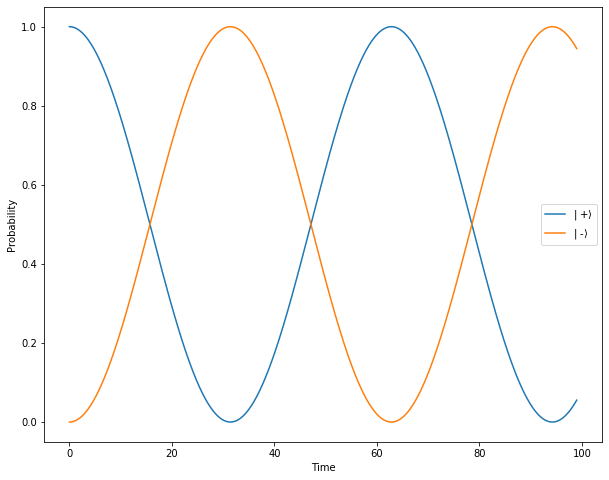

In [7]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("")
plt.show();

The Rabi frequency (and hence the difference in energy of the stationary states) is now given by $A$ because we introduced the $1/2$ into the Hamiltonian.

Now back to 2 TSS. If these are considered to be independent, then we should be able to work out the probabilities from above.

In [8]:
P2 = np.zeros([4,times.size], dtype="complex128")
P2[0,:] = P[0,:]*P[0,:]
P2[1,:] = P[0,:]*P[1,:]
P2[2,:] = P[1,:]*P[0,:]
P2[3,:] = P[1,:]*P[1,:]

In [9]:
bra_labels, ket_labels = make_braket_labels(mm_list)

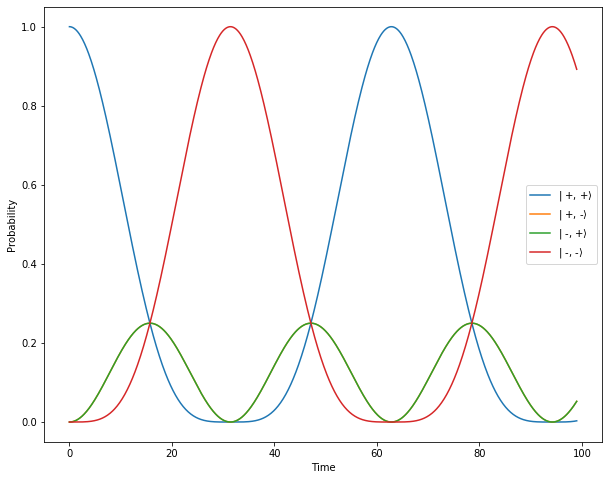

In [10]:
plt.figure(figsize=(10,8))
for i in range(0,P2.shape[0]):
    plt.plot(times, P2[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("")
plt.show();

What about the energies of the stationary states? We can have a guess by thinking that the energy difference of the levels being A. This means we can have ±A/2 for the levels. So we can have both upper giving A/2+A/2 = A, both lower giving -A or both opposite giving 0.

What about the stationary states themselves? We could probably work it out, but at this point it might be easier to try and figure out the Hamiltonian and calculate from there.

A natural starting point for the Hamiltonian of $N$  independent TSS is then


$$
H = - A \overset{N}{\underset{n=1}{\Sigma}} S_{n x}
$$

Because spin represents angular momentum, the combination of spin operators above is mathematically the same as how one would create the [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) - denoted by $J$, e.g. $Jx = \overset{N}{\underset{n=1}{\Sigma}} S_{n x}$. The Hamiltonian can then be written more compactly as:

$$
H = - A J_{x}
$$

Let's see if we can reproduce the above figure from this Hamiltonian.

QuTiP has a nice function to generate the J operators for any given number of TSS.

In [11]:
J = jspin(2, basis="uncoupled")

In [12]:
A=0.1
H = -A*J[0]

times = np.linspace(0.0, 99.0, 1000) 

psi0=basis(4,0)

P, psi = simulate(H, psi0, times)

In [13]:
bra_labels, ket_labels = make_braket_labels(mm_list)

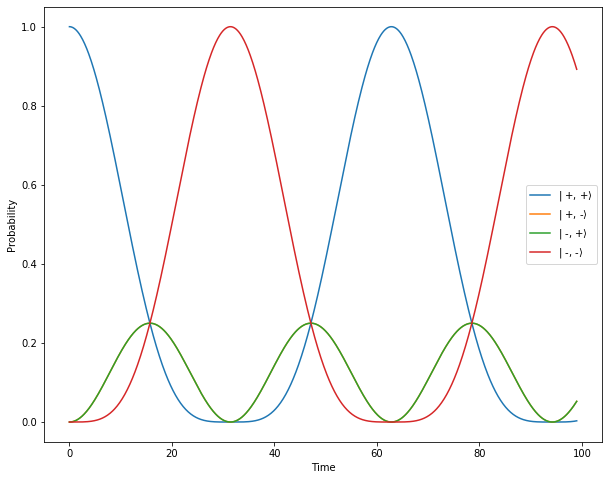

In [14]:
plt.figure(figsize=(10,8))
for i in range(0,P2.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("")
plt.show();

Great, that seemed to work! Let's take a look at the stationary states by calculating the eigenvalues and eigenstates

In [15]:
evals, ekets = H.eigenstates()

In [16]:
evals

array([-1.00000000e-01,  0.00000000e+00,  9.71445147e-17,  1.00000000e-01])

The eigenvalues are as we predicted.

In [17]:
prettify_states(ekets, mm_list)

,0,1,2,3
"(+, +)",0.5+0.0j,0.0+0.0j,0.7+0.0j,0.5+0.0j
"(+, -)",0.5+0.0j,0.7+0.0j,0.0+0.0j,-0.5+0.0j
"(-, +)",0.5+0.0j,-0.7+0.0j,0.0+0.0j,-0.5+0.0j
"(-, -)",0.5+0.0j,0.0+0.0j,-0.7+0.0j,0.5+0.0j


Although the stationary states look a bit complicated they are actually just combinations of the 2 stationary states from the single TSS, i.e.

- |+> + |->
- |+> - |->

For example, column 0 (the state corresponding to energy = -0.1) is made from:

$$(|+> + \ |->) \otimes (|+> + \ |->) = |+,+> +\ |+,-> + \ |-,+> + \ |-,->$$

What else can we learn from this system?

Just like in Tutorial 2, we can perturb the system and see what happens.


## Perturbing 2 TSS

We imagine some kind of perturbing field that affects all the TSS in the same way.

We can extend the Hamiltonian to include a perturbation $\delta$ in a similar way to above:

$$
H = - A J_{x} + \delta J_{z}
$$

where here $J_z = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$

We proceed as we have done several times by looking for the stationary states of the system. When the system is in one of these states it will remain there for all time. Such states are described by a single constant energy.


We'll calculate the eigenvalues of the Hamiltonian (i.e the energies) and see how they depend on the perturbation strength $\delta$. When we did this in Tutorial 2 we discovered an avoided crossing (aka anti-crossing) when the perturbation was zero - this was due to the coupling between the states splitting the energy levels apart.

Let's see what we find.

In [18]:
J = jspin(2, basis="uncoupled")

In [19]:
df = make_df_for_energy_scan("$\delta$/A", -4,4, 100, J[0].shape[0]) 

In [20]:
for i, row in df.iterrows():
    H = - A*J[0] + row[ "$\delta$/A"]*A*J[2]
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

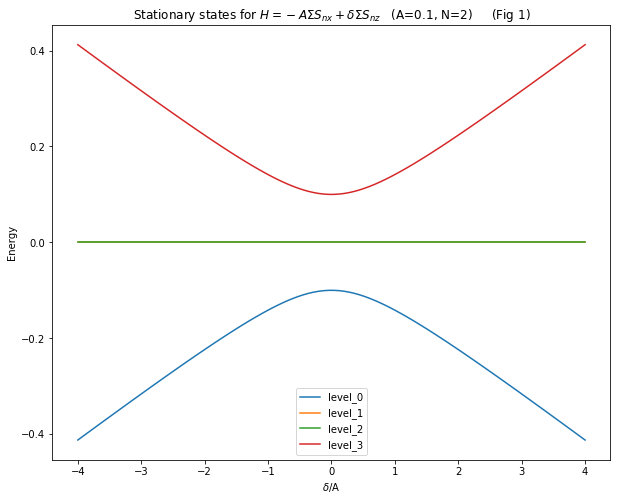

In [21]:
df.plot(x="$\delta$/A",figsize=(10,8),legend=True, 
        title="Stationary states for $H=-A\Sigma S_{nx} + \delta \Sigma S_{nz}$   (A=0.1, N=2)     (Fig 1)");
plt.ylabel("Energy");

We see that level_0 and level_3 show a similar dependency on $\delta$ that we saw in tutorial 2. What is most interesting is level_1 and level_2 whose energy does not show any dependence on $\delta$. Let's explore what the eigenstates look like for the $\delta/A=4$ case (the last value calculated in the above loop)

In [22]:
evals

array([-4.12310563e-01, -2.22044605e-16,  0.00000000e+00,  4.12310563e-01])

In [23]:
prettify_states(ekets, mm_list)

,0,1,2,3
"(+, +)",-0.0+0.0j,-0.2+0.0j,0.0+0.0j,1.0+0.0j
"(+, -)",-0.1+0.0j,-0.7+0.0j,0.7+0.0j,-0.1+0.0j
"(-, +)",-0.1+0.0j,-0.7+0.0j,-0.7+0.0j,-0.1+0.0j
"(-, -)",-1.0+0.0j,0.2+0.0j,0.0+0.0j,0.0+0.0j


What is most striking is that the state corresponding to level_2 (column 2) is the same as when we had $\delta = 0$. Then it was denoted as level_1.

What does this mean?

Let's try and answer this questions by using a technique we employed in tutorial 2, namely using a resonant time dependent perturbation, i.e.

$$
H = - A J_{x} + \delta J_{z} \cos(\omega t)
$$

with $\omega = A$.

The idea is to start the system off in a stationary state of the unperturbed system - we will start with of on the middle energies, specifically level 2 - and see what happens. We know that when the system depends explicitly on time, the energy of the system in not conserved so we expect the state to not be fixed in time. We also saw this effect explicitly in Tutorial 2.

In [83]:
J = jspin(2, basis="uncoupled")

In [84]:
delta = 0.001
A = 0.1

H0 = -A*J[0]

evals, ekets = H0.eigenstates()

H1 =  delta*J[2]

H = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 20000.0, 1000) 

psi0 = ekets[3]

result = sesolve(H, psi0, times, args={'w':A})


Now that we have simulated the system, it is convenient to transform the state vector into the basis consisting of stationary states of $H_0$. This removes fast oscillations arising from the Rabi oscillations.

In [85]:
num_states = result.states[0].shape[0]
psi = np.zeros([num_states,times.size], dtype="complex128")
P = np.zeros([num_states,times.size], dtype="complex128")

for i, state in enumerate(result.states):
    transformed_state = state.transform(ekets)
    psi[:,i] = np.transpose(transformed_state)
    P[:,i] = np.abs(psi[:,i]*np.conj(psi[:,i]))

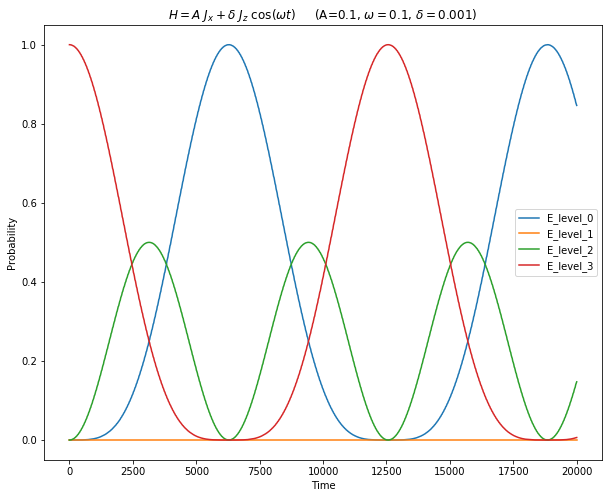

In [86]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"E_level_{i}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H =A \ J_x + \delta \ J_z \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$)")
plt.show();

Just like in tutorial 2, we see that oscillations on a timescale related to $\delta$. Specifically, now that we have incorporated the factor of $1/2$ into the Hamiltonian, the oscillation in this case is $\delta/2$

In [47]:
2*np.pi/(delta)

6283.185307179586

We see several things that are interesting:
1. At around 3000 we see that there is a 50:50 chance of the system being in the upper or lower energy level. We can think of this as the chance of the combined 2 TSS undergoes stimulated absorption or emission.
2. Throughout the simulation there is zero chance of the system moving to level 1.

On 2, When we look at level 1, we find that it's the state that is unaffected by $\delta$ that we spoke of earlier.

In [51]:
prettify_states(ekets, mm_list)

,0,1,2,3
"(+, +)",0.5+0.0j,0.0+0.0j,0.7+0.0j,0.5+0.0j
"(+, -)",0.5+0.0j,0.7+0.0j,0.0+0.0j,-0.5+0.0j
"(-, +)",0.5+0.0j,-0.7+0.0j,0.0+0.0j,-0.5+0.0j
"(-, -)",0.5+0.0j,0.0+0.0j,-0.7+0.0j,0.5+0.0j


It seems like state 1 is unable to couple to the other 3. Let's see this explicitly by starting the simulation off in state 1.

In [52]:
delta = 0.001
A = 0.1

H0 = -A*J[0]

evals, ekets = H0.eigenstates()

H1 =  delta*J[2]

H = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 20000.0, 1000) 

psi0 = estates[1]

result = sesolve(H, psi0, times, args={'w':A})


In [53]:
num_states = result.states[0].shape[0]
psi = np.zeros([num_states,times.size], dtype="complex128")
P = np.zeros([num_states,times.size], dtype="complex128")

for i, state in enumerate(result.states):
    transformed_state = state.transform(estates)
    psi[:,i] = np.transpose(transformed_state)
    P[:,i] = np.abs(psi[:,i]*np.conj(psi[:,i]))

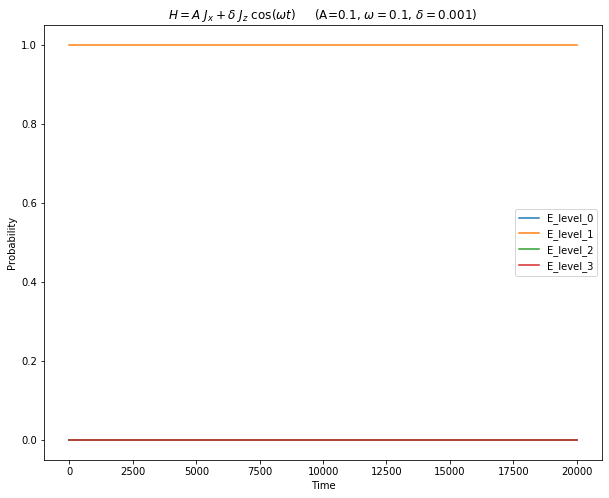

In [54]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"E_level_{i}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H =A \ J_x + \delta \ J_z \  \cos (\omega t)$     (A=0.1, $\omega = 0.1$, $\delta=0.001$)")
plt.show();

This result is striking. It looks like state 1 lives in its own universe. Also, This says that in this state, the combined system is incapable of absorbing or emitting radiation. This is a new property that we would not have expected from our Hamiltonian that was supposed to be 2 independent TSS. 

How would the independent system behave?

## Dicke basis

In [495]:
def j_states_list(num_tss):
    i=0
    
    jm_list = []
    j_index = {}

    js = j_vals(num_tss)[::-1]
    
    for j in js:
        j_index[j] = []
        ms = m_vals(j)[::-1]
        for m in ms:
            j_index[j].append(i)
            jm_list.append((j,m))
            i+=1
    return j_index, jm_list

In [505]:
def make_braket_labels(jm_list):
    bra_labels = ["$\langle$"+str(Fraction(j))+", "+str(Fraction(m))+" |" for (j,m) in jm_list]
    ket_labels = ["| "+str(Fraction(j))+", "+str(Fraction(m))+"$\\rangle$" for (j,m) in jm_list]
    return bra_labels, ket_labels

In [178]:
def make_operators(num_tss, j):
    
    j_index, jm_list = j_states_list(num_tss)
    
    try:
        j_index[j]
    except:
        raise Exception(f"j needs to be one of {j_vals(num_tss)}")
    
    Js = jspin(num_tss)
    Jx = Js[0]
    Jz = Js[2]
    

    
    num_ms = len(m_vals(j))
    Jz = Jz.extract_states(j_index[j])
    Jx = Jx.extract_states(j_index[j])
    jm_list = [jm_list[i] for i in j_index[j]]
    
    
    
    return Jz, Jx, jm_list

In [543]:
Jz, Jx, jm_list = make_operators(6, 3)

In [544]:
df = make_df_for_energy_scan("$\Delta E$/A", -4,4, 100, Jz.shape[0])

In [545]:
A=0.1
for i, row in df.iterrows():
    H =  row[ "$\Delta E$/A"]*A*Jz +  A*Jx
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

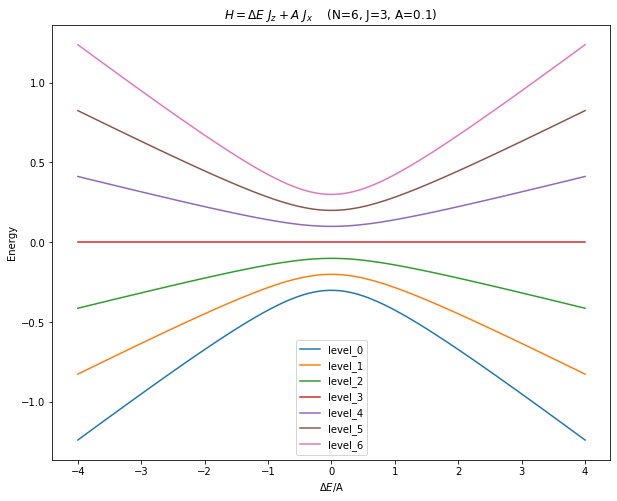

In [546]:
df.plot(x="$\Delta E$/A",figsize=(10,8),legend=True, 
        title="$H=\Delta E \ J_z + A \ J_x$    (N=6, J=3, A=0.1) ");
plt.ylabel("Energy");

In [169]:
bra_labels, ket_labels = make_braket_labels(jm_list)

In [353]:
delta = 0.001
A = 0.1

H0 = A*Jx

evals, estates = H0.eigenstates()

H1 =  delta*Jz

H = [H0,[H1,'cos(w*t)']]

times = np.linspace(0.0, 20000.0, 1000) 

#psi0=basis(4,0)
psi0 = estates[0]

result = sesolve(H, psi0, times, args={'w':A})

# result = sesolve(H0, basis(7,0), times)



In [354]:
num_states = result.states[0].shape[0]
psi = np.zeros([num_states,times.size], dtype="complex128")
P = np.zeros([num_states,times.size], dtype="complex128")

for i, state in enumerate(result.states):
    transformed_state = state.transform(estates)
    psi[:,i] = np.transpose(transformed_state)
    P[:,i] = np.abs(psi[:,i]*np.conj(psi[:,i]))

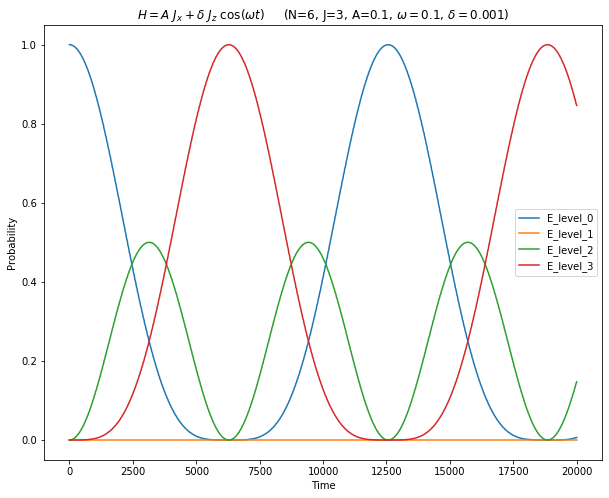

In [355]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"E_level_{i}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H =A \ J_x + \delta \ J_z \  \cos (\omega t)$     (N=6, J=3, A=0.1, $\omega = 0.1$, $\delta=0.001$)")
plt.show();

In [548]:
H0 = A*Jx

In [549]:
evals, estates = H0.eigenstates()

In [550]:
evals

array([-3.00000000e-01, -2.00000000e-01, -1.00000000e-01,  2.22044605e-16,
        1.00000000e-01,  2.00000000e-01,  3.00000000e-01])

In [551]:
estates

array([Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.125     ]
 [-0.30618622]
 [ 0.48412292]
 [-0.55901699]
 [ 0.48412292]
 [-0.30618622]
 [ 0.125     ]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[-0.30618622]
 [ 0.5       ]
 [-0.39528471]
 [ 0.        ]
 [ 0.39528471]
 [-0.5       ]
 [ 0.30618622]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.48412292]
 [-0.39528471]
 [-0.125     ]
 [ 0.4330127 ]
 [-0.125     ]
 [-0.39528471]
 [ 0.48412292]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[-0.55901699]
 [ 0.        ]
 [ 0.4330127 ]
 [ 0.        ]
 [-0.4330127 ]
 [ 0.        ]
 [ 0.55901699]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), type = ket
Qobj data =
[[ 0.48412292]
 [ 0.39528471]
 [-0.125     ]
 [-0.4330127 ]
 [-0.125     ]
 [ 0.39528471]
 [ 0.48412292]],
       Quantum object: dims = [[7], [1]], shape = (7, 1), ty

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18266ea908>)

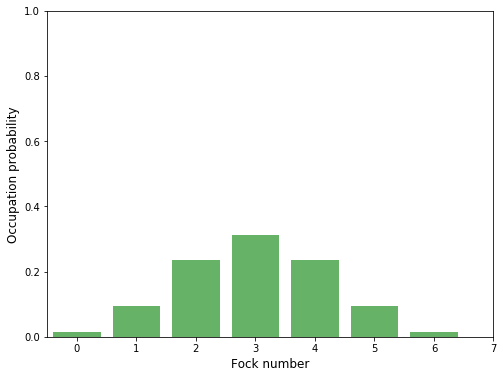

In [554]:
plot_fock_distribution(estates[6])

In [273]:
jm_list

[(3.0, 3.0),
 (3.0, 2.0),
 (3.0, 1.0),
 (3.0, 0.0),
 (3.0, -1.0),
 (3.0, -2.0),
 (3.0, -3.0)]

[Wolfram alpha eigenvalues](https://www.wolframalpha.com/input/?i=%7B%7B1%2Ca%2C0%7D%2C%7Ba%2C0%2Ca%7D%2C%7B0%2Ca%2C-1%7D%7D+eigenvalues)



https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf

https://ocw.mit.edu/courses/physics/8-05-quantum-physics-ii-fall-2013/lecture-notes/MIT8_05F13_Chap_10.pdf

https://www.ks.uiuc.edu/Services/Class/PHYS480/qm_PDF/chp6.pdf

https://quantummechanics.ucsd.edu/ph130a/130_notes/node312.html